# Sentimental

Foundations of Data Science Assessed Exercise 2

## Abstract

This Python Notebook aims to perform Sentiment Analysis on the SST-2 dataset. I compare and contrast the efficiency of both Count Vectorization and TF-IDF Vectorization methods with a variety of traditional machine learning models. After the best model combination has been determined, I use feature selection algorithms to evaluate the importance of feature selection and tune the classifier's hyperparameters in order to improve the models accuracy. Overall, an classification accuracy of 92.99% and 83.72% was achieved on the training and testing data respectively.

**Keywords:**

sentiment analysis, sst-2, sklearn, logistic regression

## Introduction

In this Python Notebook, we will perform Sentiment Analysis via Machine Learning using the Stanford Sentiment Treebank dataset (SST-2). The proposed Machine Learning model will be trained on the `train.tsv` file and tested on the `dev.tsv` from SST-2. 

Run the following cells to load the dataset. If the respective files are not in the same file directory as this notebook, you may need to edit the below variables to select the appropriate file locations. We can then load the datasets using the Pandas library.

In [1]:
import pandas as pd

# Assigns the filepath to the train_data and test_data variable
train_data = 'train.tsv'
test_data = 'dev.tsv'

# Loads the train.tsv and dev.tsv datasets. As the files are .tsv files it is necessary to specificy sep='t'
train = pd.read_csv(train_data, sep='\t')
test = pd.read_csv(test_data, sep='\t')

When running the following cell, we can see that the data comprises of a sentence column (the input features) and a label column, comprising of 1s and 0s which correspond to either positive or negative sentiment respectively. After vectorizing the data, we can train a binary classification model on the transformed data. 

In [2]:
train.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In the following sections, I analyse two text vectorization methods and four classification algorithms. I then attempt to improve the accuracy of the best performing combination through dimensionality reduction of the input features and hyperparameter tuning of three hyperparameters. Finally, I analyse the performance of my final machine learning model and compare it to existing benchmarks. 

### Required Modules

The below cells import the required Python libraries for this notebook. You may need to install some of the modules if they are not yet installed.

In [3]:
## Visualisations/Metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Timer/Progress bar
from tqdm import tqdm

In [4]:
## Classification Methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [5]:
## Text Vectorization Methods
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Cross-validation for Model Selection
from sklearn.model_selection import KFold, cross_val_score

In [6]:
## Feature Selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, f_classif
from sklearn.pipeline import make_pipeline

In [7]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

### Defined Functions

The following functions are used throughout this notebook.

In [8]:
def create_bag(vectorizer, data):  
    """
    Creates a bag-of-words representation of the sentences in the given data using the a text vectorization method of choice.

    Parameters:
        vectorizer : A vectorizer object that has been fitted on the sentences in SST-2 which is used to transform the input data into the BOW.
        data : A pandas dataframe corresponding to the test or training data for SST-2.

    Returns:
        pandas.DataFrame : A pandas dataframe representing the bag-of-words. The dataframe stores the counts or TF-IDF values
            of each token in each sentence.
    """
    
    bag = vectorizer.transform(data.sentence)
    arr = bag.toarray()

    features = vectorizer.get_feature_names_out()
    # Called `get_feature_names` in some sklearn versions

    bag_df = pd.DataFrame(arr, columns=features)
    bag_df.index = data.sentence

    return bag_df


def evaluate(vectorizer, classifier):
    """
    Evaluates the accuracy of the provided classifier given a train-test split of data using a specified text vectorization method.

    Parameters:
        vectorizer : A vectorizer object that has been fitted on the sentences in SST-2 which is used to create a BOW to 
            be used as input for the classifier.
        classifier : A machine learning classifier object that will be fitted and trained on the SST-2 training data.

    Returns:
        tuple: A tuple containing the training accuracy and test accuracy of the trained classifier.
    """
    
    train_X = create_bag(vectorizer, train) 
    train_y = train['label']
    
    test_X = create_bag(vectorizer, test)
    test_y = test['label']
        
    classifier.fit(X=train_X, y=train_y)
        
    train_accuracy = classifier.score(train_X, train_y)
    test_accuracy = classifier.score(test_X, test_y)
    
    return (train_accuracy, test_accuracy)

## Methods

### Vectorization and Classification Model Selection

This section involves a comparison of different text vectorization methods with different machine learning models. 

The text vectorization methods, Count Vectorizer and TF-IDF Vectorizer, are instantiated and fitted to the corpus of text provided in the 'Sentence' column of the training data. Then, the machine learning models are instantiated. I have attempted to choose a variety of different classification algorithms. 

In [9]:
vectorizers = [CountVectorizer(min_df=2).fit(train.sentence), 
               TfidfVectorizer(min_df=2).fit(train.sentence)]         

In [10]:
classifiers = [MultinomialNB(),
               LogisticRegression(max_iter=10000), 
               DecisionTreeClassifier(max_depth=12),
               RandomForestClassifier(max_depth=5)]

Next I iterate through both the `vectorizers` and `classifiers` lists. Within this evaluation process, I use each vectorizer to create a bag of words from the training data and then use this to train each classifier. Once the model is fitted, the train and test accuracy is calculated and added to a list of scores.

The `scores` list is then converted into a pandas dataframe.

In [11]:
scores = []

for vectorizer in vectorizers:
    for classifier in tqdm(classifiers):
        train_accuracy, test_accuracy = evaluate(vectorizer, classifier)
        scores.append((str(type(vectorizer).__name__), str(type(classifier).__name__), train_accuracy, test_accuracy))

100%|████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.77s/it]


In [12]:
scores_df = pd.DataFrame(scores, columns=['Vectorizer', 'Classifier', 'Train Accuracy', 'Test Accuracy'])
scores_df

,Vectorizer,Classifier,Train Accuracy,Test Accuracy
0,CountVectorizer,MultinomialNB,0.894920,0.806193
1,CountVectorizer,LogisticRegression,0.937772,0.818807
2,CountVectorizer,DecisionTreeClassifier,0.627374,0.610092
3,CountVectorizer,RandomForestClassifier,0.559103,0.511468
4,TfidfVectorizer,MultinomialNB,0.905656,0.800459
5,TfidfVectorizer,LogisticRegression,0.922864,0.825688
6,TfidfVectorizer,DecisionTreeClassifier,0.627864,0.622706
7,TfidfVectorizer,RandomForestClassifier,0.559726,0.512615


From the dataframe, we can see that Logistic Regression performed the best, followed by Multinomial Naive Bayes and that the Count Vectorizer achieves higher accuracy than the TF-IDF Vectorizer. Below, I use `matplotlib` to visualise the data as bar charts in order to compare and contrast the effectiveness of each combination of vectorizer and classifier for both the training and testing data.

Text(0, 0.5, 'Accuracy Score')

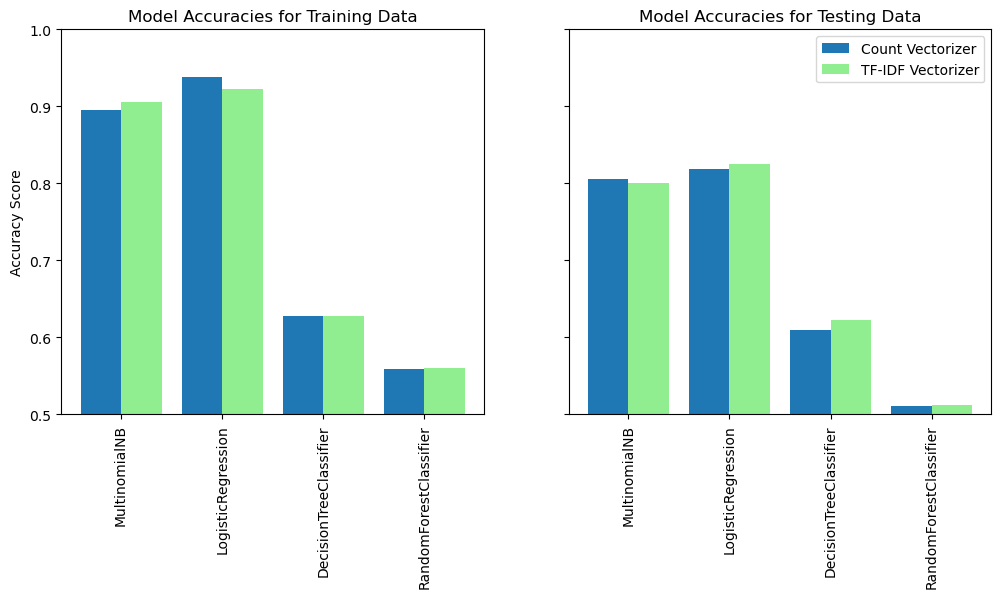

In [13]:
# Two side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)


ax1.set_title('Model Accuracies for Training Data')
# In order to group together the results by classifier, we have to manually specify the locations on the x-axis and then override the x-labels
X_axis = np.arange(len(scores_df['Classifier'])/2)
# Select and plot the two types of vectorizer separately with appropriate x offset.
ax1.bar(X_axis - 0.2, scores_df[scores_df["Vectorizer"] == "CountVectorizer"]['Train Accuracy'], width =  0.4, label='Count Vectorizer')
ax1.bar(X_axis + 0.2, scores_df[scores_df["Vectorizer"] == "TfidfVectorizer"]['Train Accuracy'], width =  0.4, color='lightgreen', label='TF-IDF Vectorizer')
# Override x-labels
ax1.set_xticks(X_axis, scores_df[scores_df["Vectorizer"] == "CountVectorizer"]['Classifier'], rotation = 90)
ax1.set_ylim([0.5, 1])


ax2.set_title('Model Accuracies for Testing Data')
# Same as above
X_axis = np.arange(len(scores_df['Classifier'])/2)
ax2.bar(X_axis - 0.2, scores_df[scores_df["Vectorizer"] == "CountVectorizer"]['Test Accuracy'], width =  0.4, label='Count Vectorizer')
ax2.bar(X_axis + 0.2, scores_df[scores_df["Vectorizer"] == "TfidfVectorizer"]['Test Accuracy'], width =  0.4, color='lightgreen', label='TF-IDF Vectorizer')
# Override x-labels
ax2.set_xticks(X_axis, scores_df[scores_df["Vectorizer"] == "CountVectorizer"]['Classifier'], rotation = 90)
ax2.set_ylim([0.5, 1])


# Displays the Legend. Since the legend is the same for both subplots, I have chosen to display the legend only on ax2
ax2.legend()

ax1.set_ylabel('Accuracy Score')

Multinomial NB and Logistic Regression both performed well with over 80% accuracy on the test data, scoring much higher then the other two classifiers. Logistic Regression achieves the highest train and test accuracy, with train and test accuracies of 92.29% and 82.57%. 


Despite Count Vectorizer performing well on training data, the highest performing combination for the test dataset is Logistic Regression with TF-IDF Vectorizer. Thus, from now on TF-IDF Vectorizer will be our text vectorization method of choice and Logistic Regression will be our machine learning model. 

### Hyper-parameter Tuning and Feature Selection

In the following sub-section I attempt to improve our baseline 82.57% accuraccy for Logistic Regression using TF-IDF Vectorizer through feature selection and hyper-parameter tuning methods, including feature dimensionality reduction via K-Best, GridSearchCV and manual tuning.

#### Feature Selection

First, I create a Logistic Regression model object and TF-IDF Vectorizer model object. `max_iter=10000` has been specified in order to avoid convergence issues with the Logistic Regression's default solver. At this intial stage, `min_df=2` has been chosen for TF-IDF Vectorizer so that words that only appear in one sentence are eliminated. This can help reduce memory usage whilst working with the large dataset, and helped speed up evaluation times during the model selection phase. 


Then I assign the feature and input variables which are required to fit our classifier. The `_X` variables are bag-of-words using TF-IDF vectorization and the `_y` variables are the respective sentiment labels for each sentence. 

In [14]:
logistic_regression = LogisticRegression(max_iter=10000)

vectorizer = TfidfVectorizer(min_df=2)

In [15]:
train_X = create_bag(vectorizer.fit(train.sentence), train)
train_y = train['label']

test_X = create_bag(vectorizer.fit(train.sentence), test)
test_y = test['label']

For the feature selection process, I evaluate 10 possible reduced dimension sizes between 9,000 and 13,331 (the maximum number of features and the current number of features without any feature reduction). 

The top k features according to their F-Score are extracted from the data (where k is the specified number between 9,000 and 13,331) as well as the features with zero variance are removed. The extractor object is then fitted to the training and testing data, providing new feature sets for both. The classification model is then fitted to the training data with feature selection and the test accuracy is recorded in `feature_scores`. This is repeated for each number in `features`. `feature_scores` is used to create a dataframe of scores which can be viewed below. This data is then visualised as a scatter plot.

In [16]:
features = np.linspace(9000, 13331, 10)
feature_scores = []

for num in tqdm(features):
    extractor = make_pipeline(VarianceThreshold(threshold=0),
                              SelectKBest(score_func=f_classif, k=int(num)))

    extractor.fit(train_X, train_y)

    trainP = extractor.transform(train_X)
    testP = extractor.transform(test_X)
    
    classifier = logistic_regression.fit(X=trainP, y=train_y)
    accuracy = classifier.score(testP, test_y)

    feature_scores.append((int(num), accuracy))

100%|██████████████████████████████████████████████████████████| 10/10 [09:21<00:00, 56.11s/it]


In [17]:
feature_scores_df = pd.DataFrame(feature_scores, columns=['Number of Features', 'Test Accuracy'])
feature_scores_df = feature_scores_df.sort_values(by='Number of Features')
feature_scores_df

,Number of Features,Test Accuracy
0,9000,0.823394
1,9481,0.823394
2,9962,0.824541
3,10443,0.825688
4,10924,0.822248
5,11406,0.824541
6,11887,0.823394
7,12368,0.823394
8,12849,0.824541
9,13331,0.825688


A polynomial regression is used to give a general idea of the trend in the data. This is for visualisation purposes only and ought not be used to predict the best number of features due to the limited training data points. However, this could be a worthwhile method if much more data was generated during the previous cell. 

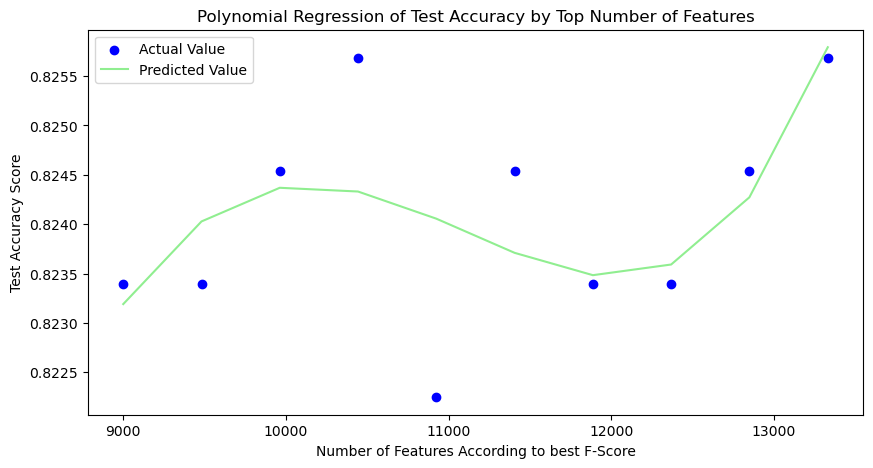

In [18]:
y = feature_scores_df['Test Accuracy'].values
x = feature_scores_df['Number of Features'].values

# Specifies the degree of the polynomial regression (used to give a general idea of the trend of the data)
poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(x.reshape(-1, 1))
# Creates a polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

# Depicts the polynomial graph
plt.figure(figsize=(10,5))
plt.scatter(x,y, c='blue', label='Actual Value')
plt.plot(x, y_predicted, c="lightgreen", label='Predicted Value')
plt.title('Polynomial Regression of Test Accuracy by Top Number of Features')
plt.xlabel("Number of Features According to best F-Score")
plt.ylabel('Test Accuracy Score')
plt.legend()
plt.show()

In [20]:
# Select the reduced dimension size with the highest test accuracy in the dataframe
best_features = feature_scores_df['Test Accuracy'].argmax()
best_num = feature_scores_df['Number of Features'].iloc[best_features]
best_num

10443

The number of features that achieved the highest test accuracy is 10,443. But this is the same acuracy as with the full number of features (82.57%). Whilst feature selection adds a step to the process, reducing the number of features and thus the size of the dataset has merit as it makes the sentiment analysis task less memory intensive and speeds up processing times. Thus, from this point on I opt to select only the top 10,443 features.

In [21]:
# Creates the new feature set
extractor = make_pipeline(VarianceThreshold(threshold=0),
                          SelectKBest(score_func=f_classif, k=int(best_num)))

extractor.fit(train_X, train_y)

trainP = extractor.transform(train_X)
testP = extractor.transform(test_X)

#### Hyper-parameter Tuning

We can further improve the accuracy by tuning the hyper-parameters. 

In [22]:
print(f'The hyper-parameters for Logistic Regression are:\n')
params = logistic_regression.get_params()
for param, default in params.items():
    print(f'... {param:25s}: {default}')
print()

The hyper-parameters for Logistic Regression are:

... C                        : 1.0
... class_weight             : None
... dual                     : False
... fit_intercept            : True
... intercept_scaling        : 1
... l1_ratio                 : None
... max_iter                 : 10000
... multi_class              : auto
... n_jobs                   : None
... penalty                  : l2
... random_state             : None
... solver                   : lbfgs
... tol                      : 0.0001
... verbose                  : 0
... warm_start               : False



##### **Solver**:

Firstly, I will compare and contrast the efficiency of each solver for Logistic Regression. Grid Search is used to search over the solver values. Whilst Grid Search is ideal for search over multiple hyperparameters, this is both a computationally and memory expensive technique unless working with very small datasets. This technique uses 5-fold cross-validation to split the data. Since our data is already split into `train.tsv` and `dev.tsv` and grid search is limited to the training data, it is important to bear in mind that the results may not translate fully when applied to our train-test split. For this reason, and due to memory contraints, K-Fold cross-validation has not been used for model selection or for further hyperparameter tuning.

The classifier trained with the best parameters from the Grid Search is then fitted to data (with feature selection from the previous experiment), before calculating the respective accuracy scores. The results of the Grid Search can be seen below.

In [25]:
grid = {
    'solver': ['newton-cg', 'saga', 'sag', 'lbfgs', 'liblinear'],
    'max_iter': [10000],
}

# Stratified k-fold ensures that the classes are balanced in each fold
cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(LogisticRegression(), grid, n_jobs=1, cv=cv)
# n_jobs can be set to speed up search, however this uses more memory

gs.fit(X=trainP, y=train['label']);

In [26]:
print(f'The best parameters for Logistic Regression are {gs.best_params_}, achieving {gs.best_score_:.2%} classification accuracy.')

print(f'Best training accuracy is {gs.best_score_:.2%}')

print(f'Test accuracy is {gs.score(testP, test_y):.2%}')

The best parameters for Logistic Regression are {'max_iter': 10000, 'solver': 'liblinear'}, achieving 89.01% classification accuracy.
Best training accuracy is 89.01%
Test accuracy is 82.57%


According to the GS, the best solver is 'liblinear'. However, there is no improvement in accuracy over 'lbfgs', and hence, solver does not seem to play a major part in the classification process in this case. I have chosen to use 'liblinear' over 'lbfgs' since it avoids the previously mentioned convergence issue and allows me to compare and contrast 'l1' penalty against 'l2' penalty, unlike 'lbfgs' that only supports 'l2' penalty. Liblinear is also less computationally expensive than other solvers such as 'newton-cg' or 'saga'.

##### **C Value and Penalty**:

Secondly, I experiment with a range of C values with both 'l1' and 'l2' penalties. 

As previously mentioned, grid search cross-validation is a memory intensive technique that is ideal for small amounts of data. To select the hyper-parameter values more accurately I create my own grid search that evaluates the accuracy for each value for my train, test split. I do this via for-loops, and consider C values between 0.1 and 15 with both 'l1' and '12' penalty, and store this data in the `hp_scores_df` dataframe. This approach proved to be faster and allowed me to evaluate many more values than with using `GridSearchCV`. It also enables me to store all the data points and plot these on a scatter chart.

In [27]:
hp_scores=[]

solver = 'liblinear'
# Generates 50 evenly spaced values between 0.1 and 15.
C_values = np.linspace(0.1, 15, 50)
penalties = ['l1', 'l2']

# For each combination of parameters, fit the classifier with the parameters and record the test accuracy.
for penalty in penalties:
    for C in tqdm(C_values):
        logistic_regression = LogisticRegression(solver=solver, C=C, penalty=penalty, max_iter=10000)
        classifier = logistic_regression.fit(X=trainP, y=train_y)
        test_accuracy = classifier.score(testP, test_y)
        hp_scores.append((C, penalty, test_accuracy))

100%|██████████████████████████████████████████████████████████| 50/50 [02:56<00:00,  3.54s/it]


In [30]:
hp_scores_df = pd.DataFrame(hp_scores, columns=['C Value', 'Penalty', 'Test Accuracy'])
hp_scores_df = hp_scores_df.sort_values(by='C Value')

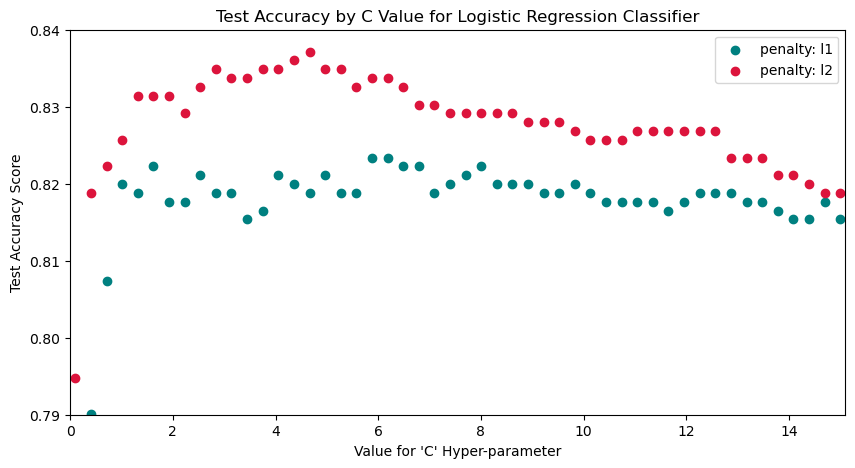

In [31]:
# Separately select and plot the results for each penalty type.
l1_y = hp_scores_df[hp_scores_df["Penalty"] == "l1"]['Test Accuracy'].values
l1_x = hp_scores_df[hp_scores_df["Penalty"] == "l1"]['C Value'].values

l2_y = hp_scores_df[hp_scores_df["Penalty"] == "l2"]['Test Accuracy'].values
l2_x = hp_scores_df[hp_scores_df["Penalty"] == "l2"]['C Value'].values

plt.figure(figsize=(10,5))
plt.scatter(l1_x,l1_y, c='teal', label='penalty: l1')
plt.scatter(l2_x,l2_y, c='crimson', label='penalty: l2')
plt.xlim(0, 15.1)
plt.ylim(0.79, 0.84)
plt.legend()
plt.title('Test Accuracy by C Value for Logistic Regression Classifier')
plt.xlabel("Value for 'C' Hyper-parameter")
plt.ylabel('Test Accuracy Score')
plt.show()

From the visualisation we can see that 'l2' penalty produces the higher test accuracy for all C values used. Moreover, the optimal range for C value seems to be between 2 and 6.5. Hence, I further test 20 more C values in this range to ensure the best C value between 2 and 6.5 is discovered, and append these data points to the original `hp_scores` list. At this stage, I only test C values with 'l2' penalty. I then generate a new expanded data frame and visualise the accuracies per each C value on a scatter graph, with a fourth degree polynomial to map the trend in the data. 

In [32]:
C_values = np.linspace(2, 6.5, 20)

for C in tqdm(C_values):
    # For each C-value, fit the classifier and record test accuracy
    logistic_regression = LogisticRegression(solver=solver, C=C, penalty='l2', max_iter=10000)
    classifier = logistic_regression.fit(X=trainP, y=train_y)        
    test_accuracy = classifier.score(testP, test_y)
    hp_scores.append((C, penalty, test_accuracy))
    
    
more_hp_scores_df = pd.DataFrame(hp_scores, columns=['C Value', 'Penalty', 'Test Accuracy'])
more_hp_scores_df = more_hp_scores_df.sort_values(by='C Value')
more_hp_scores_df

100%|██████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.45s/it]


,C Value,Penalty,Test Accuracy
0,0.100000,l1,0.735092
50,0.100000,l2,0.794725
51,0.404082,l2,0.818807
1,0.404082,l1,0.790138
2,0.708163,l1,0.807339
...,...,...,...
47,14.391837,l1,0.815367
48,14.695918,l1,0.817661
98,14.695918,l2,0.818807
99,15.000000,l2,0.818807


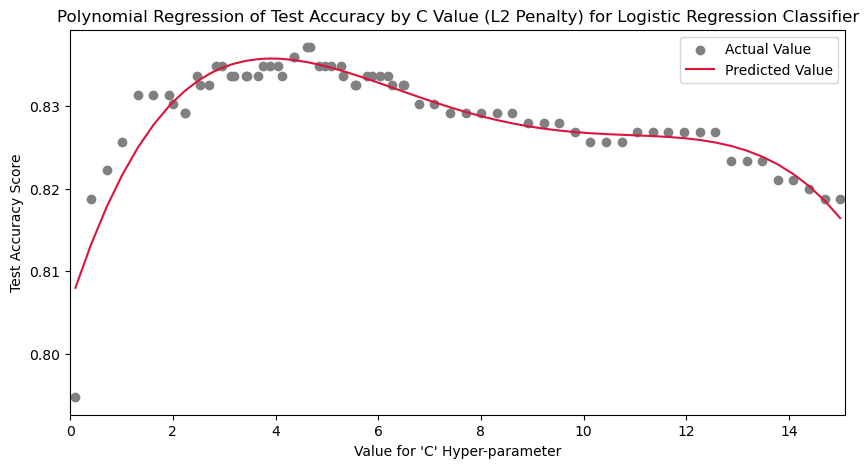

In [33]:
y = more_hp_scores_df[more_hp_scores_df["Penalty"] == "l2"]['Test Accuracy'].values
x = more_hp_scores_df[more_hp_scores_df["Penalty"] == "l2"]['C Value'].values

poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(x.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

plt.figure(figsize=(10,5))
plt.scatter(x,y, c='grey', label='Actual Value')
plt.plot(x, y_predicted, c="crimson", label='Predicted Value')
plt.xlim(0, 15.1)
plt.title('Polynomial Regression of Test Accuracy by C Value (L2 Penalty) for Logistic Regression Classifier')
plt.xlabel("Value for 'C' Hyper-parameter")
plt.ylabel('Test Accuracy Score')
plt.legend()
plt.show()

In [34]:
best = more_hp_scores_df['Test Accuracy'].argmax()

best_solver = 'liblinear'
best_c = more_hp_scores_df['C Value'].iloc[best]
best_penalty = more_hp_scores_df['Penalty'].iloc[best]
best_accuracy = more_hp_scores_df['Test Accuracy'].iloc[best]

print(f"The best hyper-parameters for Logistic Regression are: \n solver:'{best_solver}', \n C: {best_c}, \n penalty: {best_penalty}. \nAchieving accuracy of {best_accuracy:.2%}")

The best hyper-parameters for Logistic Regression are: 
 solver:'liblinear', 
 C: 4.605263157894736, 
 penalty: l2. 
Achieving accuracy of 83.72%


## Results

From my experiments I have determined that the most appropriate model is `LogisticRegression(solver= 'liblinear', C=4.605263157894736)` (the default penalty is 'l2' so this does not need to be specified), using `TfidfVectorizer(min_df=2)` and a reduced feature set of 10,443 features. When applied to the test data, the classification accuracy is 83.72%.

In [35]:
# Creates a Logisitic Regression object with proposed hyperparameters
logistic_regression_tuned = LogisticRegression(C=best_c, penalty=best_penalty, solver=best_solver)

In [36]:
# Trains proposed Logistic Regression classifier on reduced feature set
classifier = logistic_regression_tuned.fit(X=trainP, y=train_y)

The classification report for the proposed model is printed below. 

In [37]:
predictions = classifier.predict(testP)
report = classification_report(test['label'], predictions)
print('Classification report for {}: \n'.format(classifier))
print(report)

Classification report for LogisticRegression(C=4.605263157894736, solver='liblinear'): 

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       428
           1       0.82      0.88      0.85       444

    accuracy                           0.84       872
   macro avg       0.84      0.84      0.84       872
weighted avg       0.84      0.84      0.84       872



In order to fully evaluate the effectiveness of a model, more than just accuracy must be considered.

The proposed model displays both high precision and recall, where high precision suggests low false positive rate, and high recall suggests a low false negative rate. The confusion matrix shows the number of true negatives, false negatives, false positives and true positives. Via the heatmap, we can see that the number of true positives and true negatives is high.

AUC-ROC score: 0.9802


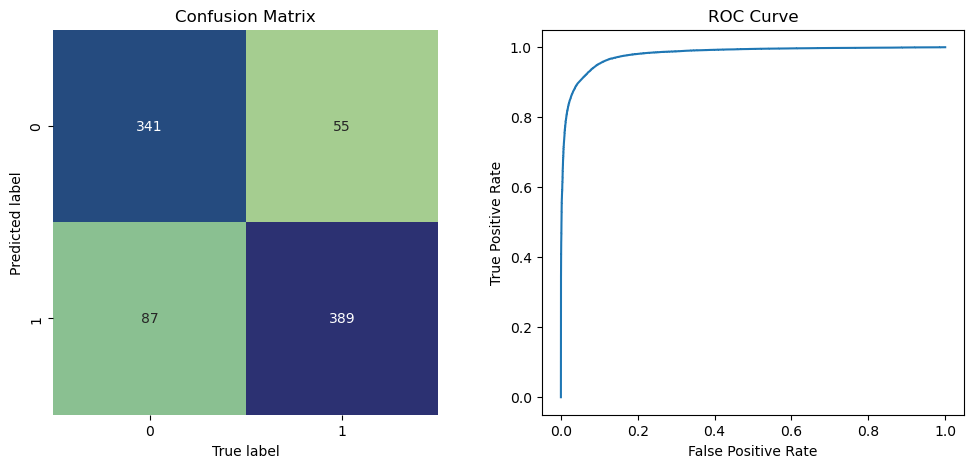

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
C = confusion_matrix(test_y, predictions)
sns.heatmap(C.T,
            square=True,
            annot=True,
            fmt='d',
            cmap='crest',
            cbar=False,
            ax=ax1)

ax1.set(title='Confusion Matrix', xlabel='True label', ylabel='Predicted label');

# PR Curve
train_y_prob = logistic_regression_tuned.predict_proba(trainP)[:,1]
fpr, tpr, threshold = roc_curve(train_y, train_y_prob)
prd = RocCurveDisplay(fpr=fpr, tpr=tpr)
ax2.set(title='ROC Curve')
prd.plot(ax=ax2)
print(f"AUC-ROC score: {roc_auc_score(train_y, train_y_prob):.4f}")

The Receiver Operating Characteristic (ROC) graph shows the effect of changing the classification threshold on the TPR and FPR. From this, we can calculate the Area Under the Curve (AUC) score, for which an ideal classifier would score 1 (corresponding to a graph from (0,0) -> (0,1) -> (1,1)). Note that I chose ROC rather than Precision-Recall since the latter is generally only preferred when the data is imbalanced.

### Conclusion

Positioned with respect to the leader-board for SST-2 (available at: https://gluebenchmark.com/leaderboard/), my model is significantly less accurate that the highest current scorer for SST-2, 'Vega V1', which achieves 97.9% accuracy. However, this is likely due to the more simplistic nature of the techniques used in my proposed Logistic Regression classifier, as most state-of-the-art models appear to use more advanced machine learning architectures such as transformers.  

In the following cells, I have generated both the train and test accuracy for:
- The original model using Logistic Regression and Count Vectorizer, which I consider my baseline
- Logistic Regression and TF-IDF Vectorizer
- Logistic Regression and TF-IDF Vectorizer (LR,TF-IDF) on reduced set of features
- LR,TF-IDF on reduced set of features with added hyper-parameter tuning 

From the bar chart below you can see the improvement in test accuracy with each amendment to the model. 

In [39]:
models =    {'LR and Count Vectorizer': LogisticRegression(max_iter=10000).fit(X=create_bag(vectorizers[0], train), y=train_y),
             'LR and TF-IDF Vectorizer': LogisticRegression(max_iter=10000).fit(X=train_X, y=train_y)}

models_fs = {'+ Feature Selection': LogisticRegression(max_iter=10000).fit(X=trainP, y=train_y),
             '+ Hyperparameter Tuning': classifier}              

In [40]:
results = [('Vega V1', None, 0.979)]

for name, model in models.items():
    train_accuracy = model.score(train_X, train_y)
    test_accuracy = model.score(test_X, test_y)
    results.append((name, train_accuracy, test_accuracy))
for name, model in models_fs.items():
    train_accuracy = model.score(trainP, train_y)
    test_accuracy = model.score(testP, test_y)
    results.append((name, train_accuracy, test_accuracy))
    
results_df = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Test Accuracy'])
results_df

,Model,Train Accuracy,Test Accuracy
0,Vega V1,NaN,0.979000
1,LR and Count Vectorizer,0.929279,0.792431
2,LR and TF-IDF Vectorizer,0.922864,0.825688
3,+ Feature Selection,0.913332,0.825688
4,+ Hyperparameter Tuning,0.929873,0.837156


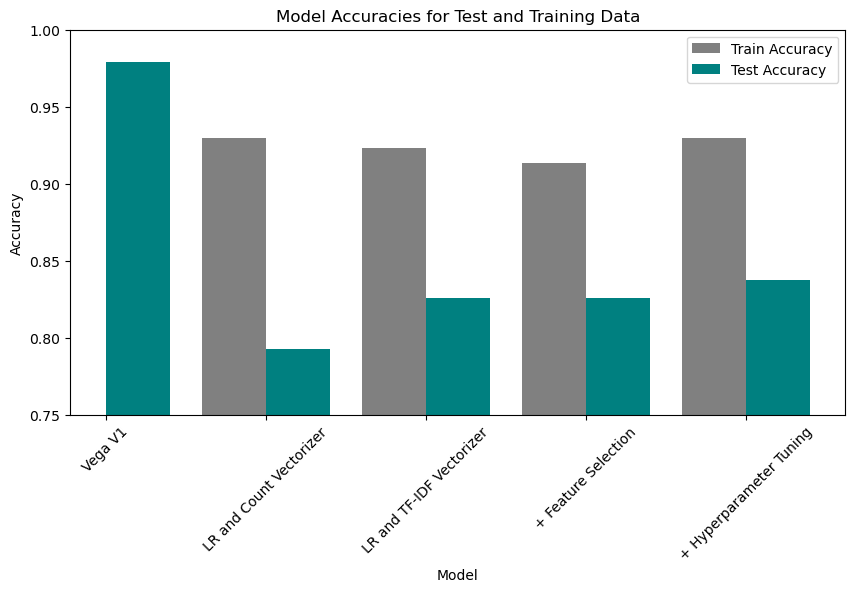

In [41]:
x=results_df['Model'].values
y=results_df['Train Accuracy'].values
z=results_df['Test Accuracy'].values

plt.figure(figsize=(10, 5))
barwidth = 0.25
# Again, manually calculate x-locations for each (train, test) result pair
X_axis = np.arange(len(results_df['Model']))
plt.bar(X_axis-0.2, y, label='Train Accuracy', width=0.4, color='grey')
plt.bar(X_axis+0.2, z, label='Test Accuracy', width=0.4, color='teal')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for Test and Training Data')
plt.xticks(X_axis, results_df['Model'], rotation=45)
plt.ylim([0.75, 1])
plt.legend()

The final proposed model has a train accuracy of 92.99% and a test accuracy of 83.72%. Whilst this is markedly lower than the 'Vega V1' accuracy of 97.9%, my results show an improvement from my baseline 79%. Using TF-IDF Vectorizer increases test accuracy to 82.56% and feature reduction improves processing time, allowing for more thorough hyperparameter testing. Finally, hyperparameter tuning increases the model to 83.72% with only a small reduction in train accuracy. 

## Ethical Implications

Sentiment analysis is useful for businesses during marketing analytics as well as recommender systems. Furthermore, sentiment analysis can improve Human-Computer Interaction by helping computers understand both natural language as well as positive versus negative interactions.

However, some consider sentiment analysis an invasion of ones privacy. Sentiment analysis often requires a large amount of data, which can include personal information about individuals, in the case of SST-2 those who have written the movie reviews. Moreover, as sentiment analysis models focus more on context, models make use of even more data to gather contextual knowledge about the utterer of the sentence during the classification process, which contributes to the feeling of 'mass surveillance' on behalf of companies and organisations, or in extreme cases - authoritarian governments. This is especially pertinant since many individuals are not aware that their data is being analysed. Thus it is important to ensure that private information is not used for sentiment analysis without consent. 

## Reference List:

Gusarova, Maria (2022) Logistic Regression Model Tuning. Available at: https://medium.com/@data.science.enthusiast/logistic-regression-tune-hyperparameters-python-code-fintech-does-it-bring-any-value-619e172565e6

Matplotlib 3.7.1 documentation (2023) Creating multiple subplots using plt.subplots. Available at: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html 

scikit-learn 1.2.2 documentation (2023). Available at: https://scikit-learn.org/stable/

Mohammad, Saif. (2022). Ethics Sheet for Automatic Emotion Recognition and Sentiment Analysis. Available at: https://direct.mit.edu/coli/article/48/2/239/109904/Ethics-Sheet-for-Automatic-Emotion-Recognition-and